# Document Clustering of News Articles

After setting up a new GitHub repository and creating a virtual environment, I first install all required modules into the environment.

In [63]:
!pip install pandas numpy scikit-learn matplotlib sentence-transformers

  Using cached sentence_transformers-2.1.0-py3-none-any.whl
  Using cached sentencepiece-0.1.96-cp39-cp39-win_amd64.whl (1.1 MB)


# Text inspection 

Let's load the required modules

In [1]:
import pandas as pd
import numpy as np

Let us load the texts and labels first and check whether the index in both files (`preproc_texts.csv` and `labels.csv`) can be assumed as reasonable document ID.

In [9]:
texts = pd.read_csv('./preproc_texts.csv', header=None, names=['text'])
labels = pd.read_csv('./labels.csv', header=None, names=['label'])

In [29]:
df = texts.merge(labels, left_index=True, right_index=True)
df.sample(5)

,text,label
8,Air pollution in national parks as bad as some...,pollution_national_parks
15,Health Minister Ginette Petitpas Taylor unveil...,health_foodguide_canada
3,An innovative high school robotics team from M...,robotics_team_builds_wheelchair
35,Imagine lying in bed for weeks on end eating a...,artificial_bed_rest_nasa_study
1,Earlier today we wrote that Microsoft was goin...,linux_kernel_windows


Form the small sample below, it looks like that the row index reflects indeed the document ID since document labels seem to reasonably reflect the documents' content.

Let us quickly check whether the labels are balanced in the data? This is important since unbalanced data typically requires special consideration when training classification models (e.g. inverse class weights).

<AxesSubplot:>

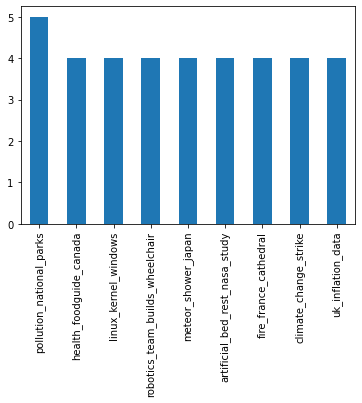

In [20]:
labels.label.value_counts().plot(kind="bar")

Lucky us, the distribution across the class labels is highly balanced ;)! That is a good starting point to train a classification model.

How does the length of the texts look like? Any outliers?

<AxesSubplot:ylabel='Frequency'>

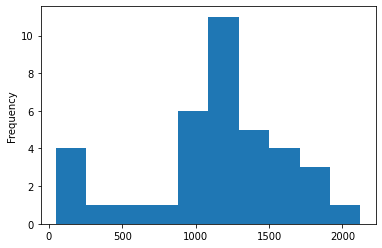

In [23]:
texts.text.apply(len).plot(kind="hist")

There are some rather small news texts. Are they somehow special which is why we should treat them as "outliers" possibly removing from further analysis?

In [30]:
df.loc[df.text.apply(len)<500].style.set_properties(subset=['text'], **{'width': '900px'})

,text,label
10,Climate change is the greatest threat that we all face but it is the school kids of today whose futures are most on the line They are right to feel let down by the generation before them and it inspiring to see them making their voice heard today,climate_change_strike
12,Why did this happen Please make sure your browser supports JavaScript and cookies and that you are not blocking them from loading For more information you can review our Terms of Service and Cookie Policy,pollution_national_parks
14,What term do you want to search Search with google,uk_inflation_data
28,Researchers at Iowa State and Cornell universities looked at more than two decades of data on ozone pollution at parks from Shenandoah to Yellowstone the Grand Canyon and Yosemite They say visitor numbers dropped almost percent when ozone levels went up even slightly and by at least percent in months with three or more days of high ozone levels compared with months with fewer days of high ozone,pollution_national_parks
32,Historian Camille Pascal told French broadcaster BFMTV that invaluable heritage had been destroyed adding Happy and unfortunate events for centuries have been marked by the bells of Notre Dame We can be only horrified by what we see,fire_france_cathedral


Indeed, it looks like that the news text with indices **12** and **14** do not really represent news articles. To me, these observations should be disregarded. Scraping can sometimes be painful ;)

In [32]:
df.drop(index=[12,14], inplace=True)

In [33]:
df.shape

(35, 2)

# Text clustering

I can think of two approaches to conduct the clustering depending on wehther the labels are known to us as modelers or not:

- If they are not known, we need to think of an effective way to vectorize the texts' *context* -> unsupervised clustering task 

- If they are known to us, we shall use them! -> clustering as supervised classification task

## Unsupervised clustering task

First, we vectorize the texts using the power of pre-trained transfomer models. These large (many parameters) neural networks with a complex architecture (bidirectional encoders) that trained on massive amount of text corpora. Exploiting the word co-occurence statistics from these text corpora allows to represent a sequence of text as dense vector. These dense vectors, in turn, allow a meaningful representation of the texts' context and are a good starting point to build clusters.

In [107]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

Load the pretrained model:


In [127]:
transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [128]:
text_embeddings = transformer.encode(df.text.apply(lambda x: x.lower()).reset_index(drop=True))

In [129]:
clusters = KMeans(n_clusters=9, random_state=0).fit(text_embeddings)

In [130]:
clusters.labels_

array([4, 2, 3, 3, 7, 1, 4, 0, 8, 8, 5, 5, 7, 4, 3, 6, 1, 7, 0, 2, 5, 7,
       6, 5, 1, 8, 8, 3, 4, 6, 0, 2, 2, 1, 0])

In [131]:
df['cluster'] = clusters.labels_

In [138]:
pd.pivot_table(df, index=['label'], columns=['cluster'], aggfunc=lambda x: str(len(x)), fill_value='')

text                        
cluster                            0  1  2  3  4  5  6  7  8
label                                                       
artificial_bed_rest_nasa_study        4                     
climate_change_strike                             4         
fire_france_cathedral              4                        
health_foodguide_canada                        4            
linux_kernel_windows                     4                  
meteor_shower_japan                                     4   
pollution_national_parks                                   4
robotics_team_builds_wheelchair             4               
uk_inflation_data                                    3

## Clustering as supervised classification task

As text labels shall reflect the document cluster, we can think of this task as a (semi-)supervised scenario. Different model approaches exist for this purpose.

Let's start with a simple discriminative classification model which takes vectorized texts as feature inputs and text labels as targets. Unlike common classifiers whose performance is typically evaluated on a hold out test set, in a clustering task, the ultimate goal is to cluster (group) the *given* texts (no train-(eval)-test split necessary). 

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Specifying a ML-pipeline to conveniently allow for hyper-parameter tuning.

In [39]:
pipeline = Pipeline([
    # Vectorization of texts
    ('vectorizer', TfidfVectorizer(
        analyzer='word',                   # words as tokens
        token_pattern='(?u)\\b\\w\\w+\\b', # default regex to split texts into word tokens
        lowercase=True                     # lowercase words before tokenization which has not been done as part of the pre-processing 
    )),
    # Classification model:
    # Unlike other classification models such SVMs or neural networks, the tree-based structure of a RF is easier to grasp
    # colleagues without quantitative background. It is important to communicate work to stakeholders!
    ('classifier', RandomForestClassifier(
        n_jobs=-1                          # run fitting of trees in parallel thereby efficiently using all our processing power
    ))
    ])

Define search spaces for those hyperparameters that shall be tuned in the subsequent random search.

In [51]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1),               # ignore words which appear in more than the given fraction of documents - typically they carry no signal to discriminate between classes
    'vectorizer__use_idf': (True, False),               # try both simple count vectorization and weighted count vectorization
    'classifier__n_estimators': (50, 100, 150),         # how many trees to train
    'classifier__min_samples_split': (2, 3, 4),         # minimum number of splits within a tree
    'classifier__min_samples_leaf': (1, 2, 3, 4),       # minimum number of observations in terminal leafs
}

In [49]:
search = RandomizedSearchCV(
    pipeline,
    parameters,
    n_iter=100,
    n_jobs=-1,
    cv = 2)

In [50]:
%%time
search.fit(df.text, df.label)

Wall time: 7.45 s


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                             ('classifier',
                                              RandomForestClassifier(n_jobs=-1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__min_samples_leaf': (1, 2,
                                                                         3, 4),
                                        'classifier__min_samples_split': (2, 3,
                                                                          4),
                                        'classifier__n_estimators': (50, 100,
                                                                     150),
                                        'vectorizer__max_df': (0.5, 0.75, 1),
                                        'vectorizer__use_idf': (True, False)})

In [62]:
accurarcy = sum(search.predict(df.text)==df.label)/len(df)
accurarcy

1.0

Classes reflect clusters and classification model allows perfect clustering. But unlikely that classes are known and discriminative nature of model leads to overfitting!